In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
import time

import sys
sys.path.insert(0, '..')
import specsens as ss

   infs left at  0.00%
 59.52s left at  0.33%
 60.30s left at  0.67%
 59.46s left at  1.00%
 60.99s left at  1.33%
 59.09s left at  1.67%
 60.65s left at  2.00%
 59.40s left at  2.33%
 66.18s left at  2.67%
 66.21s left at  3.00%
 57.83s left at  3.33%
 57.91s left at  3.67%
 57.39s left at  4.00%
 68.46s left at  4.33%
 71.21s left at  4.67%
 66.63s left at  5.00%
 56.39s left at  5.33%
 58.76s left at  5.67%
 56.22s left at  6.00%
 57.51s left at  6.33%
 56.23s left at  6.67%
 57.30s left at  7.00%
 55.62s left at  7.33%
 55.87s left at  7.67%
 55.12s left at  8.00%
 55.26s left at  8.33%
 54.64s left at  8.67%
 54.98s left at  9.00%
 54.33s left at  9.33%
 55.72s left at  9.67%
 53.81s left at 10.00%
 64.08s left at 10.33%
 57.72s left at 10.67%
 53.39s left at 11.00%
 53.84s left at 11.33%
 52.88s left at 11.67%
 53.17s left at 12.00%
 52.87s left at 12.33%
 53.07s left at 12.67%
 53.41s left at 13.00%
 52.73s left at 13.33%
 52.96s left at 13.67%
 52.24s left at 14.00%
 51.87s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in double_scalars


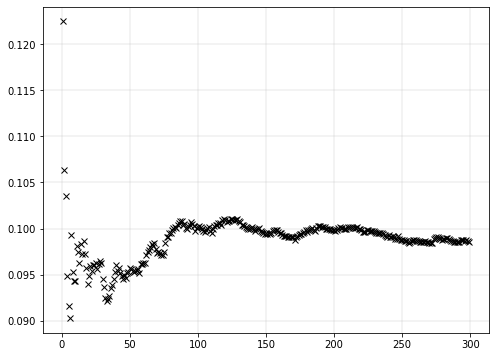

Theory     pfa 0.1
Simulation pfa 0.09850502962577916
Theory     pd  0.9608106474202457
Simulation pd  0.9609995908929949


In [6]:
n_bands = 1 
n_fft = 1024
n_stats = 1024 // n_bands
band_to_detect = 0

class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):

        self.reset()
        thr = ss.chi2_stats.get_thr(
            noise_power=ss.util.dB_to_factor_power(noise_strength),
            pfa=pre_pfa,
            #             n=ss.util.get_signal_length(f_sample=sample_freq, t_sec=length))
            n=n_stats)
        length = ss.util.sample_time(f_sample=sample_freq, num_samples=n_fft)

        for i in range(self.gens):
            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

            # As soon as we introduce noise uncertainty, the detector performs badly
            # This is expected, as energy detectors cant handle noise uncertainty
            #             noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.

            for j in range(self.itrs):
                sig = wm.get_soft(f_center=1e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)

                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                # Classical energy detector
                # eng = ss.EnergyDetector.get(both)

                # Mutliband stft based energy detector
                sft = ss.Stft(
                    n=n_fft,
                    window='box')  # currently only working with box window
                f, psd = sft.stft(sig=both,
                                  f_sample=sample_freq,
                                  normalized=False,
                                  dB=False)
                edf = ss.FreqEnergyDetector(num_bands=n_bands,
                                            f_sample=1e6,
                                            fft_len=n_fft,
                                            freqs=f)
                eng = edf.detect(psd)[band_to_detect]

                # Threshold
                sig_detected = eng > thr

                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1

            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            rem, per = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))

        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()

sim = MonteCarloSim(300, 300)
pfa, pd = sim.run(signal_strength=0.,
                  noise_strength=10.,
                  sample_freq=1e6,
                  length=0.002,
                  pre_pfa=0.1)

sim.print_convergence()

print(f'Theory     pfa {0.1}')
print(f'Simulation pfa {pfa}')
print(
    f'Theory     pd  {ss.chi2_stats.get_pd(ss.util.dB_to_factor_power(10.), ss.util.dB_to_factor_power(0.), ss.chi2_stats.get_thr(10., 0.1, n_stats), n_stats)}'
)
print(f'Simulation pd  {pd}')

In [3]:
ss.util.get_signal_length(f_sample=1e6, t_sec=0.001)

1000.0